# Yash Manish Raichura

## Introduction
This individual problem set has three aims:

 learn to find problematic data (multicollinearity) using condition numbers

 see how Ridge and Lasso regressions are more stable in case of ill-conditioned data

 learn to manually create design matrices for a survey data set.

We return here to the World Value Survey data, a large survey with ∼90k observations and 430
variables. Your task is to compile a large number of variables into a design matrix. The process easily
leads to multicollinearity which you have to detect using condition numbers.
Thereafter we overfit, but as this is a fairly large dataset, we only achieve this by selecting a small
subsample of the data. You can see that overfitting is often related to large condition numbers, and may
lead to linear regression validation RMSE to be ridiculously large. But Ridge and Lasso can handle the
situation much better.

When reasonably coded, the code should run fast (∼30s), except the stepwise condition number procedure (∼10min). So you may want to be careful and not run that code too often.
Please submit a) your code (notebooks, rmd, whatever) and b) the results in a final output form (html
or pdf)

## World Values Survey

World Value Survey (WVS) is a large survey, conducted in many countries simultaneously. It revolves
around public opinion about traditions, economy, politics, life and other things. I recommend you to
consult the official questionnaire 
In this task the central question is V23:

All things considered, how satisfied are you with your life as a whole these days? with answers ranging between 1 (completely dissatisfied) and 10 (completely satisfied). We are going to model this variables using linear regression.

In [1]:
#Importing required libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt  
from pylab import *
import sklearn
import os
from scipy.stats import pearsonr
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import operator
from numpy import linalg as LA
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression as lm
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
%matplotlib inline

## 1. Explore and clean the data

### First, let's load data and take a closer look at it.

#### 1. Browse the WVS documentation and make sure you are familiar with coding of the variable V23. Note: you also have to consult the codebook to understand all the missings and how to remove those

In [2]:
#Loading the data
data = pd.read_csv('wvs.csv', sep = '\t')

In [3]:
# Printing out first 5 rows of the dataset
data.head()

,V2,V4,V5,V6,V7,V8,V9,V10,V11,V12,...,MN_228S8,MN_229A,MN_230A,MN_233A,MN_237B1,MN_249A1,MN_249A3,I_RELIGBEL,I_NORM1,I_VOICE1
0,12,1,1,1,-2,1,1,2,1,1,...,3,-3,-3,-3,-3,1,1,0.0,1.0,0.00
1,12,1,2,3,4,2,2,2,2,2,...,3,-3,-3,-3,-3,2,-1,0.0,1.0,0.66
2,12,1,3,2,4,2,1,2,2,2,...,4,1,1,2,-3,1,1,0.0,1.0,0.33
3,12,1,1,3,4,3,1,2,1,2,...,2,2,1,2,-3,1,2,0.0,1.0,0.00
4,12,1,1,1,2,1,1,1,3,2,...,2,2,1,2,-3,1,2,0.0,1.0,0.66


In [4]:
#Shape of the data
data.shape

(90350, 328)

In [5]:
#checking for NA values
data.isna().sum()

V2               0
V4               0
V5               0
V6               0
V7               0
              ... 
MN_249A1         0
MN_249A3         0
I_RELIGBEL    4636
I_NORM1       1711
I_VOICE1      4445
Length: 328, dtype: int64

In [6]:
#Dropping NA values
data.dropna(inplace = True)
data.shape

(80744, 328)

#### 2. Load the data. Remove all the missing observations of V23. I mean all the missings, including the valid numeric codes that denote missing/invalid answers.

In [7]:
#Removing negative values from V23
data = data[data.V23 > 0]

In [8]:
#Printing out unique values
data.V23.value_counts()

8     16577
7     14033
10    10714
5      9971
6      9577
9      8491
4      4124
3      2969
1      2280
2      1706
Name: V23, dtype: int64

In [9]:
#Unique satisfaction levels
data.V23.unique()

array([ 8,  5,  4,  7,  6,  3, 10,  1,  9,  2], dtype=int64)

#### 3. Now make a table (or a plot) of different answers. What is the mean satisfaction level on this planet? How large a proportion of people are at 6 or more satisfied? (Note: without knowing more about how the sample was created, we should not talk about the planet. We should refer to respondents instead.)


In [10]:
#Mean satisfaction level
data.V23.mean()

6.872255786778052

The mean satisfaction level on this planet is 6.87

In [11]:
#Summary of count of people for each satisfaction level
table_satisfaction = data.V23.value_counts().to_frame().reset_index()
table_satisfaction.rename(columns = {'index': 'satisfaction_level', 'V23':'count'}, inplace = True)
table_satisfaction = table_satisfaction.sort_values(by = 'satisfaction_level').reset_index().drop(columns = 'index')
table_satisfaction

,satisfaction_level,count
0,1,2280
1,2,1706
2,3,2969
3,4,4124
4,5,9971
5,6,9577
6,7,14033
7,8,16577
8,9,8491
9,10,10714


In [12]:
table_satisfaction.sum().count

<bound method Series.count of satisfaction_level       55
count                 80442
dtype: int64>

In [13]:
table_satisfaction[table_satisfaction.satisfaction_level >=  6 ].sum().count

<bound method Series.count of satisfaction_level       40
count                 59392
dtype: int64>

In [14]:
#Proportion greater than or equal to 6

59392/80442*100

73.83207777031899

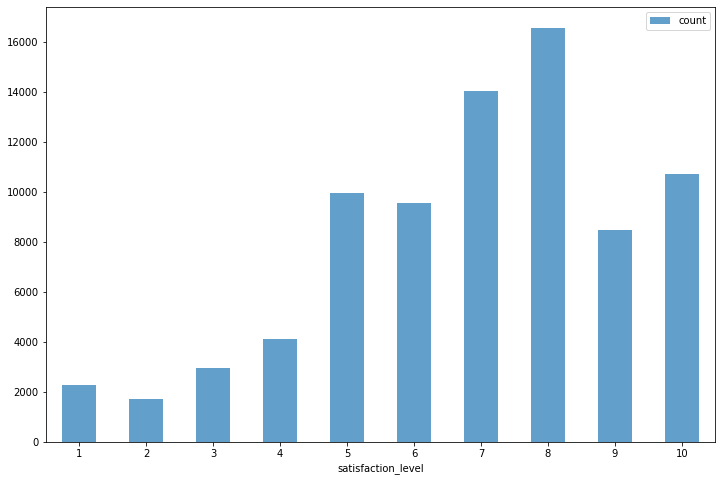

In [15]:
#Plot for count of people for each satisfaction level
table_satisfaction.plot(kind = 'bar', x = 'satisfaction_level', y = 'count', rot = 360, alpha = 0.7, figsize = (12,8))

## 2. Create the Design Matrix

Now it is time to make the data suitable for a regression model. So far we have either used R-style formulas,
or fed data into a ML model directly without much preparatory work. Now it is time to construct the
design matrix manually. In case of linear regression, the design matrix is the data matrix that will be
directly fed into the formula (X|· X)−1X|y, or any function that uses this or another similar formula.
Design matrix can also be fed directly into other kind of models, such as logistic regression or decision
tree. Design matrix is also needed by various libraries, in particular sklearn's LinearRegression, Ridge,
and Lasso

Many variables are categorical. For instance, variable V2, country, is numeric with different numbers
representing different countries. So in essence it is a categorical variable where categories are coded
as numbers. The same is true for V80, most serious problem in the world. You should convert such
variables to dummies (do your still remember pd.get_dummies?) and remove the original variable.
But don't forget to remove missings!


A large number of variables contain ordered values instead. For instance, V55 asks how much choice
do you feel do you have over your life. The answers range from 1 (no choice at all) to 10 (a great
deal of choice). We treat these as numeric response. Although, strictly speaking not correct, the
model would be too messy if we were creating a category for each response. However, the missings
(-5: inapplicable, -4: not asked etc) are not ordered in any meaningful sense. Hence your task is to
remove missings

Note that many variables, e.g. v74b (important to help people nearby) and v90 (signing petition), contain
a very large number of missings, and hence you essentially lose all your data if you include such variables.
So you should remove such variables and replace with others that have more valid answers.

In [16]:
#Renaming V2 column to country
data.rename(columns = {'V2' : 'country'}, inplace = True)

In [17]:
# Making a copy of the dataframe
X = data.copy()

#### 2. Create a design matrix that contains at least 100 variables from the WVS data. Your selected variables should contain at least a few categorical ones, such as V2 country. In each case:
#### (a) remove missing observations
#### (b) convert categorical variable to dummies if appropriate. Don't forget to drop the reference category.

In [18]:
#Finding out columns with the least negative values and printing the column values with the number of non negative values in a
#dataframe
l1 = []
l2 = []
for i in X.columns:
    l1.append(i)
    l2.append(len(X[i][X[i] > 0]))
df1 = {'column_name' : l1 , 'number_of_non_zero_values' : l2}
df1 = pd.DataFrame(df1)
df1.sort_values(by = 'number_of_non_zero_values', ascending = False, inplace = True)
df1.head(10)

,column_name,number_of_non_zero_values
0,country,80442
61,V62,80442
222,V199,80442
160,V147,80442
20,V23,80442
19,V22,80440
10,V13,80437
11,V14,80437
15,V18,80437
40,V43,80436


In [19]:
# Using the top 100 columns with the least non negative values and putting them in X
X = X[df1.head(100).column_name.to_list()]
X = X.reset_index().drop(columns = 'index')

In [20]:
#Loading the dataframe X with the values for the respective columns
for i in X.columns:
    X = X.loc[X[i] > 0]

In [21]:
#Printing out a few rows of X
X.head(10)

,country,V62,V199,V147,V23,V22,V13,V14,V18,V43,...,V40,V36,V38,V52,V110,V75,V133,V24,V70,V108
1,12,2,4,1,5,2,1,2,2,2,...,2,1,2,2,1,3,8,1,2,1
2,12,1,5,1,4,2,2,2,2,1,...,2,1,2,1,2,1,4,1,1,3
3,12,3,6,1,8,2,2,2,2,1,...,2,1,2,2,4,1,9,2,1,2
4,12,2,5,1,8,2,1,2,1,1,...,2,1,1,3,3,4,4,2,2,2
6,12,2,7,1,7,2,1,2,2,1,...,2,1,2,1,4,1,4,2,1,2
8,12,1,7,1,6,2,2,2,2,2,...,2,1,2,1,4,1,5,2,1,4
10,12,3,4,1,5,2,2,2,2,1,...,2,1,2,1,3,1,7,1,2,3
11,12,2,6,1,3,2,2,1,2,2,...,2,2,1,2,3,4,6,2,2,2
12,12,3,5,1,5,2,2,1,1,2,...,2,1,2,3,2,1,8,2,1,1
13,12,3,5,1,3,2,2,2,2,2,...,2,1,2,2,2,2,5,1,2,1


In [22]:
#Printing out rows and columns of X
X.shape

(53374, 100)

In [23]:
#Creating dummy variables for the columns V2(country) and V80
X = pd.get_dummies(data=X, columns=['country', 'V80'],drop_first=True)

In [24]:
#Printing out rows and columns of X
X.shape

(53374, 155)

#### Create your outcome variable y out of life satisfaction V23 (remove missings!)

In [25]:
y = X.V23
X = X.drop(columns = 'V23')

# Condition numbers

The next task is to compute the condition number of your design matrix. It will quite likely be way too
big: some of the answers may be highly correlated, you may forget to drop the reference category, the
reference category you drop may have no observations, there may be several variables that contain exactly
the same information... But we want to know which variables are the culprits. So instead of computing
just a single κ, let's add columns to the design matrix one-by-one, and each time printing the column we
added, and the resulting condition number.

In [26]:
#Calculating the condition number, starting from the first column and appending each column through the last column
df = pd.DataFrame()
print('Condition Numbers: ')
for i in X.columns:
    df[i] = X[i]
    k = np.linalg.cond(df)
    print(i , len(df.columns),'columns', k)  

Condition Numbers: 
V62 1 columns 1.0
V199 2 columns 2.5696655811546845
V147 3 columns 6.018316786222353
V22 4 columns 8.177085131340787
V13 5 columns 9.354500140555752
V14 6 columns 10.435482793941837
V18 7 columns 11.1435052321177
V43 8 columns 12.068451399489557
V41 9 columns 16.103800049042352
V16 10 columns 16.538618006478746
V12 11 columns 17.077034666587934
V17 12 columns 17.720960055062836
V20 13 columns 18.366965613781126
V37 14 columns 22.804667060461107
V15 15 columns 23.611802796679452
V39 16 columns 24.541776506227592
V44 17 columns 25.420672080712297
V19 18 columns 26.015909980863665
V21 19 columns 26.61143096854149
V240 20 columns 27.139376691656445
V242 21 columns 156.98122888445337
V57 22 columns 157.19368836110382
V200 23 columns 157.30099688427794
V11 24 columns 157.46339831826168
V4 25 columns 157.50505556290136
V59 26 columns 158.77222006592729
V64 27 columns 158.90243216924023
V209 28 columns 159.1971628021183
V210 29 columns 159.3294059849332
V208 30 columns 159.

## 4. Do Some Social Science

Before getting further, let's do a simple social science analysis. How is life satisfaction related to health
(v11 ), perceived control over life (v55 ) and financial situation (v59 )? Let's analyze association between
satisfaction and just these three variables.


In [27]:
#Calculating correlation between the 4 required variables
corr_df = data[['V23', 'V11', 'V55', 'V59']]
corr_df = corr_df.corr().iloc[0].to_frame().T
corr_df

,V23,V11,V55,V59
V23,1.0,-0.2747,0.358468,0.460208


#### 1. run a linear regression models explaining satisfaction with these three variables. Present the output table.

In [28]:
lm_Data = data[['V23','V11','V55','V59']]
lm_model = smf.ols(formula='V23 ~ V11 + V55 + V59', data=lm_Data).fit()
print(lm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    V23   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                 1.116e+04
Date:                Fri, 06 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:41:18   Log-Likelihood:            -1.6511e+05
No. Observations:               80442   AIC:                         3.302e+05
Df Residuals:                   80438   BIC:                         3.303e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1701      0.032    128.866      0.0

#### 2. comment the output table in terms of relative effect size and statistical significance. Any surprises for you? 

In [29]:
relative_effect_size = 0.294 / (1  - 0.294)
print('relative_effect_size:  ')
print(relative_effect_size)

relative_effect_size:  
0.4164305949008499


As seen from the correlation table, there is a negative correlation between V23 and V11 and a stronger correlation of V59 with V23 compared to V55. The linear model does decipher this relationship which is depicted with the coefficients of each of these variables

#### 3. compute and present RMSE (just on training data). This will serve as the benchmark for the future.

In [30]:
# splitting the data into test and train
from sklearn.model_selection import train_test_split
X_lm = data[['V11','V55','V59']]
y_lm = data[['V23']]

X_train,X_test,y_train,y_test = train_test_split(X_lm,y_lm,test_size=0.2)

In [31]:
#from sklearn.linear_model import LinearRegression as lm
lm_model_train = lm().fit(X_train,y_train)

In [32]:
#predict
predictions = lm_model_train.predict(X_train)
predictions

array([[7.88176837],
       [8.66436183],
       [6.76864739],
       ...,
       [7.58008667],
       [5.6257673 ],
       [8.03215259]])

In [33]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(y_train, predictions))
rmse

1.8804808855019592

The train RMSE is 1.88

# 5. Back to ML: Model

Now it is time to use all these variables to model satisfaction. Use sklearn.linear_model.LinearRegression
here as this is easy to be switched with ridge and lasso, and it takes in the design matrix directly.


#### 1. Compute the condition number for your design matrix (just a single number, not the stepwise procedure).

In [34]:
#Calculating the condition number for the design matrix
np.linalg.cond(X)

4104.921671570704

In [35]:
#Converting y to a dataframe since it was a series
y = y.to_frame()

#### 2.Split the data into training-validation chunks (80-20 or so)

In [36]:
#Splitting the dataset into train and test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

#### 3. Compute the condition number for your training design matrix (just a single number, not the stepwise procedure)

In [37]:
#Calculating the condition number for the train design matrix
np.linalg.cond(X_train)

4157.653314155036

#### 4. Fit a linear regression model where you describe satisfaction with the design matrix X you just created.


In [38]:
#Fitting the linear model
lm_model_train = lm().fit(X_train,y_train)

#### 5. predict and compute RMSE on training data


In [39]:
#Predicting values for y_train
predictions = lm_model_train.predict(X_train)
predictions

array([[4.05802689],
       [6.28613213],
       [8.0201497 ],
       ...,
       [5.31553822],
       [7.9251524 ],
       [7.6885177 ]])

In [40]:
#Calculating RMSE for train dataset
rmse = sqrt(mean_squared_error(y_train, predictions))
rmse

1.687696805971712

#### 6. Predict and compute RMSE on testing data

In [41]:
#Predicting values for y_test
predictions = lm_model_train.predict(X_test)
predictions

array([[6.55488428],
       [6.06865303],
       [7.12704207],
       ...,
       [5.11516676],
       [4.24873903],
       [7.02509167]])

In [42]:
#Calculating RMSE for test dataset
rmse = sqrt(mean_squared_error(y_test, predictions))
rmse

1.6648184866365812

#### 7. Repeat the previous with Ridge regression, play a little with different α-s. Which α gave you the best testing RMSE? (No need for a rigorous analysis, just play a little)

In [43]:
alpha = [0.01,0.01,1,10,100,1000]

In [44]:
for i in alpha:
    rr = Ridge(alpha = i)
    ridge = rr.fit(X_train, y_train)
    predictions = ridge.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, predictions))
    print('The test RMSE value for alpha =  for ridge regression is',i, 'is ', rmse)
    

The test RMSE value for alpha =  for ridge regression is 0.01 is  1.6648170358048433
The test RMSE value for alpha =  for ridge regression is 0.01 is  1.6648170358048433
The test RMSE value for alpha =  for ridge regression is 1 is  1.6647145870011186
The test RMSE value for alpha =  for ridge regression is 10 is  1.6646608513107544
The test RMSE value for alpha =  for ridge regression is 100 is  1.6654164184937383
The test RMSE value for alpha =  for ridge regression is 1000 is  1.6759989223549052


#### 8.  Repeat with Lasso regression again playing a little with different α-s

In [45]:
for i in alpha:
    lasso = Lasso(alpha=i)
    Lasso_model = lasso.fit(X_train, y_train)
    predictions =lasso.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, predictions))
    print('The test RMSE value for alpha = for lasso regression is',i, 'is ', rmse)

The test RMSE value for alpha = for lasso regression is 0.01 is  1.6922421016024198
The test RMSE value for alpha = for lasso regression is 0.01 is  1.6922421016024198
The test RMSE value for alpha = for lasso regression is 1 is  1.9505974216193782
The test RMSE value for alpha = for lasso regression is 10 is  2.2128614278132974
The test RMSE value for alpha = for lasso regression is 100 is  2.2128614278132974
The test RMSE value for alpha = for lasso regression is 1000 is  2.2128614278132974


#### 9. comment your results:
#### (a) compare RMSE on testing/training data. What does this suggest in terms of overfitting?
#### (b) compare RMSE for OLS, Ridge and Lasso
#### (c) compare the resulting RMSE with the small benchmark model you did above

(a) The RMSE value for training data is 1.68 and the RMSE value for test data is 1.67
The RMSE values do not differ much, and the test RMSE follows the Train RMSE closely, which suggests that the model is neither underfitting nor over fitting

(b) RMSE for OLS: 1.6954, RMSE for Ridge is 1.689 and RMSE for lasso is 2.19
We see that we get similar RMSE values for OLS and Ridge regression models, whereas the RMSE is a bit higher for lasso regression. In ridge regression, the model tries to decrease the coefficients, whereas in lasso, the model makes the coeffiecients of the model 0, and hence for higher values of alpha, the test rmse increase. Here, alpha corresponds to the linear dependancy.
For lasso regression, as alpha value increases, the test rmse also increases since it reduces the coefficients of the predictor variables and hence rmse for ridge is comparatively higher for higher values of alpha than ols or ridge. Whereas for lower values of alpha, ridge and lasso behave like linear models only.

(c) The RMSE value for our benchmark model is 1.86. Hence, it proves that by adding the regularization parameter (alpha), the RMSE value has reduced from 1.86 to 1.69 for the ridge model, as it introduces a small amount of bias to decrease the variance, and hence there is a decrease in the RMSE  value for test data.



# 6 Let's Overfit!

As WVS is a relatively large dataset we cannot easily overfit by adding more variables. But we can go
another easy route instead: we take a subsample

#### 1. Create a subsample of your design matrix and the outcome variable. Choose a large-ish sample that overfits. The size depends on which variables do you exactly choose, in my case 2000 obs rarely overfits (it depends on the train-validation split), 1000 typically overfits.

In [46]:
X_overfit = X[0:1000]

In [47]:
X_overfit.shape

(1000, 154)

In [48]:
y_overfit = y[0:1000]

In [49]:
y_overfit.shape

(1000, 1)

#### 2. Repeat the steps you did above

In [50]:
#Splitting the dataset into train and test
X_train,X_test,y_train,y_test = train_test_split(X_overfit,y_overfit,test_size=0.2)

In [51]:
#Fitting the linear model
lm_model_train = lm().fit(X_train,y_train)
#Predicting values for y_train
predictions = lm_model_train.predict(X_train)
rmse = sqrt(mean_squared_error(y_train, predictions))
c = np.linalg.cond(X_train)
print('Condition number for X_train ', c)
print('RMSE for train dataset', rmse)

Condition number for X_train  1.0515487240697494e+131
RMSE for train dataset 1.7791928160467982


In [52]:
#Fitting the linear model
lm_model_train = lm().fit(X_train,y_train)
#Predicting values for y_test
predictions = lm_model_train.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, predictions))
c = np.linalg.cond(X_train)
rmse
print('Condition number for X_train ', c)
print('RMSE for test dataset', rmse)


Condition number for X_train  1.0515487240697494e+131
RMSE for test dataset 2.0438664580025234


In [53]:
for i in alpha:
    rr = Ridge(alpha = i)
    ridge = rr.fit(X_train, y_train)
    predictions = ridge.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, predictions))
    print('The test RMSE value for alpha =  for ridge regression is',i, 'is ', rmse)
    

The test RMSE value for alpha =  for ridge regression is 0.01 is  2.043857106545165
The test RMSE value for alpha =  for ridge regression is 0.01 is  2.043857106545165
The test RMSE value for alpha =  for ridge regression is 1 is  2.0429496961531366
The test RMSE value for alpha =  for ridge regression is 10 is  2.036045651238214
The test RMSE value for alpha =  for ridge regression is 100 is  2.0086501016700886
The test RMSE value for alpha =  for ridge regression is 1000 is  1.9715882413952146


In [54]:
for i in alpha:
    lasso = Lasso(alpha=i)
    Lasso_model = lasso.fit(X_train, y_train)
    predictions =lasso.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, predictions))
    print('The test RMSE value for alpha = for lasso regression is',i, 'is ', rmse)

The test RMSE value for alpha = for lasso regression is 0.01 is  2.016724324088806
The test RMSE value for alpha = for lasso regression is 0.01 is  2.016724324088806
The test RMSE value for alpha = for lasso regression is 1 is  2.110957613777602
The test RMSE value for alpha = for lasso regression is 10 is  2.3388031127053
The test RMSE value for alpha = for lasso regression is 100 is  2.3388031127053
The test RMSE value for alpha = for lasso regression is 1000 is  2.3388031127053


#### 3. comment how do OLS, Ridge, Lasso perform on testing/training in case of overfitting.
#### 4. comment the condition number of design matrix and overfitting.

We see that train MSE for 1000 observations is 1.75 wheres the test MSE for linear regression is 2.11 which is higher than 1.68 which we got in the previous case where the entire design matrix was used. 
Since only a sample of the design matrix is used, the condition number is a lot higher - 4.078594937341657e+131 which denotes very little linear dependance within the predictors and the response.
This is clearly depicted by the test RMSE which is higher than train MSE and the test MSE in previous cases.

For ridge and lasso regression, for low values of alpha, it behaves similar to linear regression but as alpha increases, ridge regression reduces the values of the coefficients of the predictor variables which makes the model fit better in this case since there is not a lot of linear dependance whereas in lasso regression, it makes the coefficient of the predictors 0, which removes the dependance of the response on input variables. In such a case, where there are only 1000 observations and the predictors also reduces, the model performs poorly and hence test RMSE increases for lasso as alpha increases.